In [ ]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from argparse import Namespace

from torch import nn
from model.dataloader import load_data
from tqdm import tqdm
device='cuda:1'

train_inputs,train_lables,test_inputs,test_lables=load_data(60000,60000,device=torch.device(device))




load data set
create loader
construct data


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


3
32
reduced0:1.0


/tmp/ipykernel_2190524/1491393103.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp = torch.load('./mlp4.pth')
/tmp/ipykernel_2190524/1491393103.py:108: FutureWarning

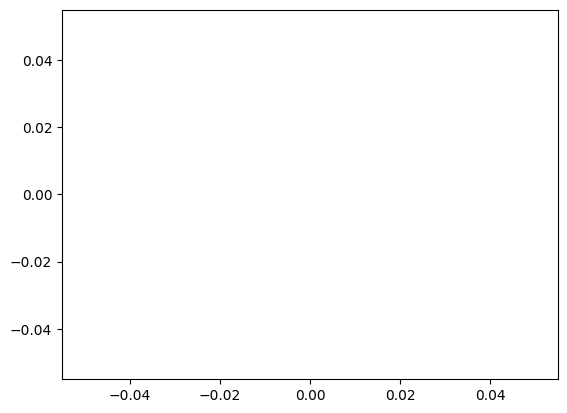

/home/tianruiming/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


10
0.1028
32
reduced0:1.0


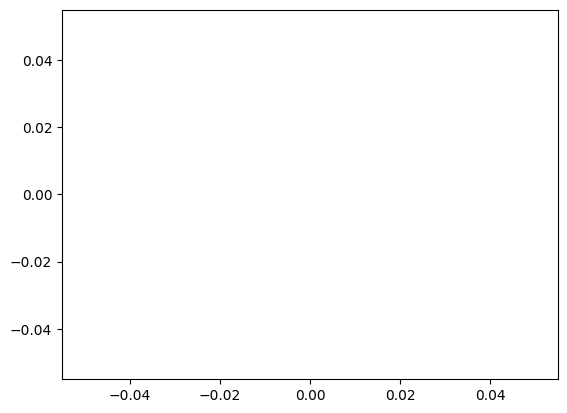

10
0.1028
32
reduced0:1.0


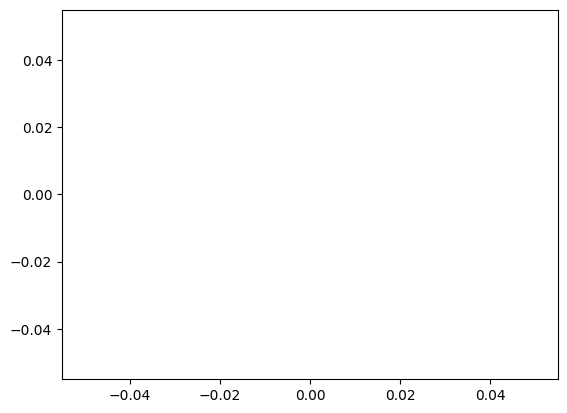

10
0.1028
32
reduced0:1.0


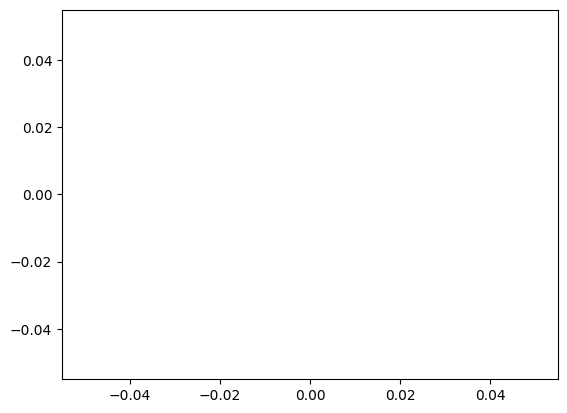

10
0.1028
32
reduced0:1.0


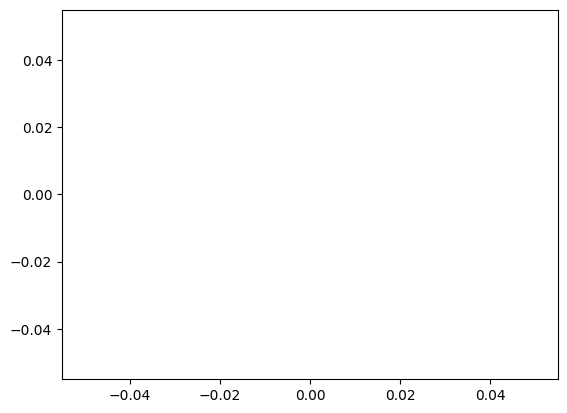

10
0.1028
32
reduced0:0.96875


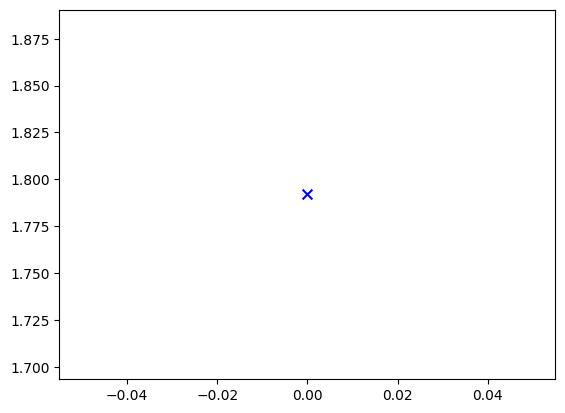

10
0.1862
32
reduced0:0.9375


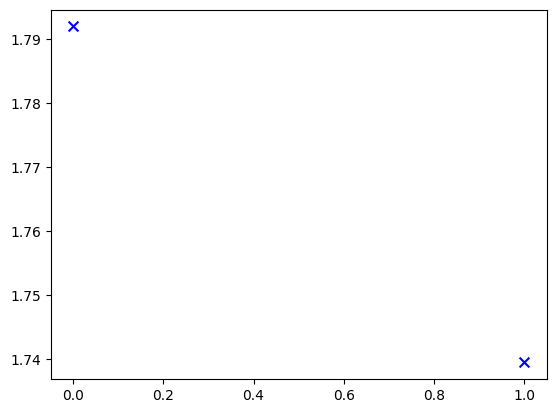

10
0.3264
32
reduced0:0.875


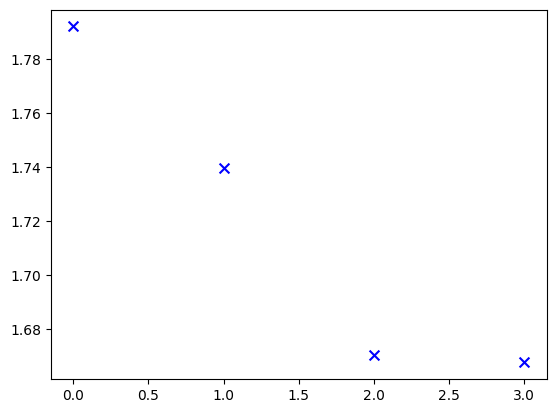

10
0.4018
32
reduced0:0.8125


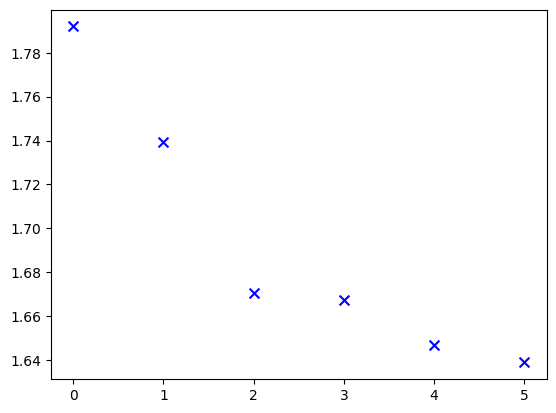

10
0.4568
32
reduced0:0.6875


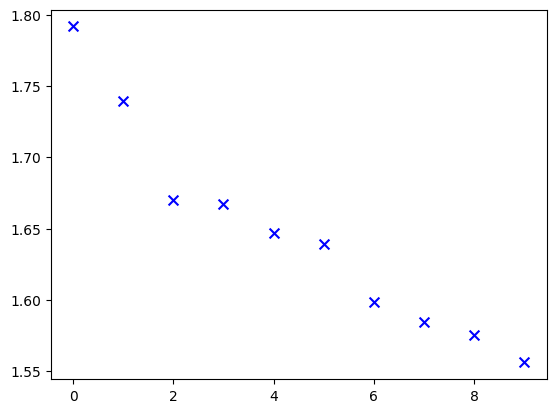

10
0.5909
32
reduced0:0.59375


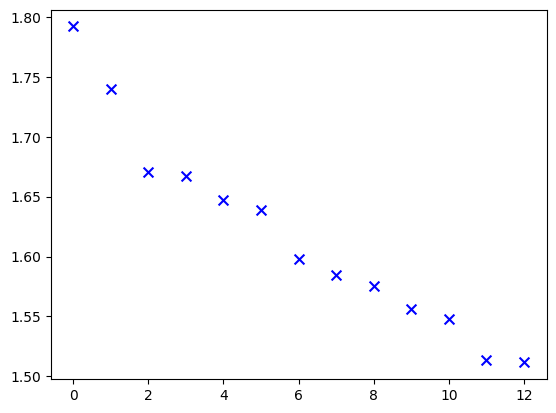

10
0.623
32
reduced0:0.53125


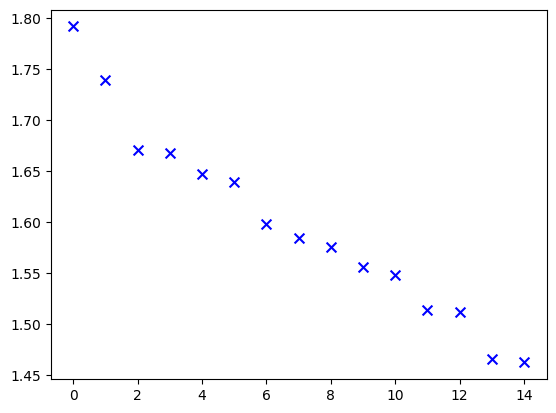

10
0.6372
32
reduced0:0.40625


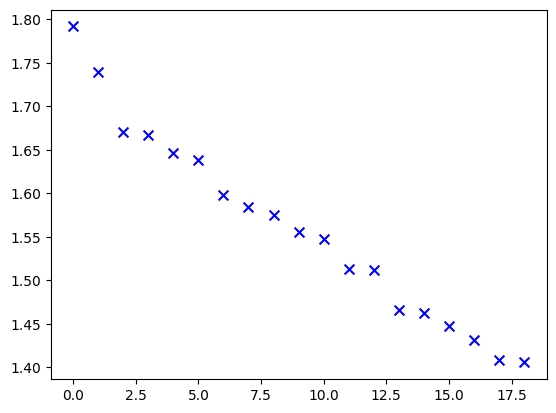

10
0.7931
32
reduced0:0.25


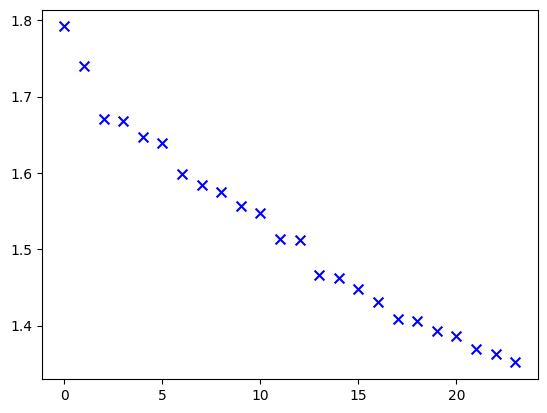

10
0.7915
32
reduced0:0.21875


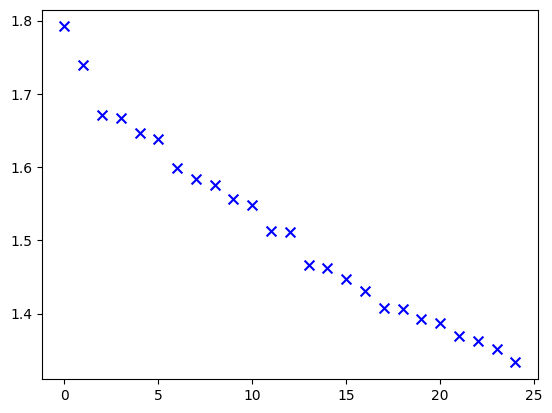

10
0.7913
32
reduced0:0.125


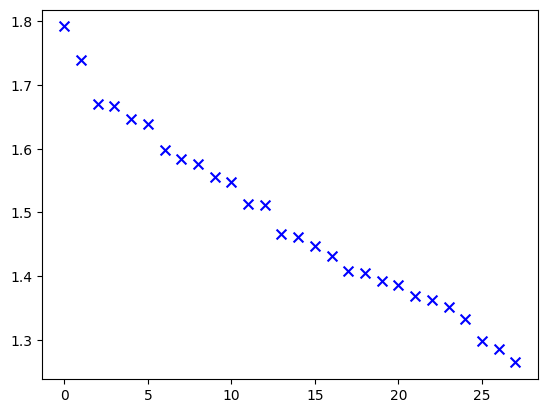

10
0.8212
32
reduced0:0.0625


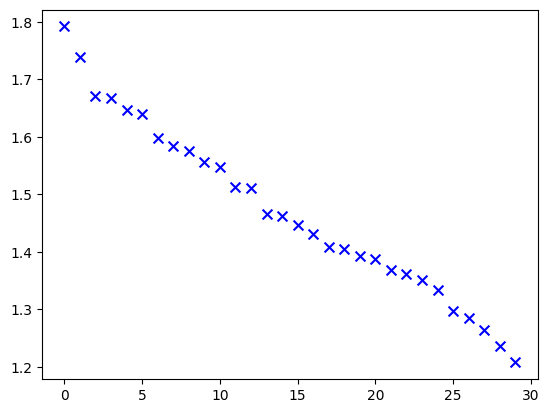

10
0.8662
32
reduced0:0.0


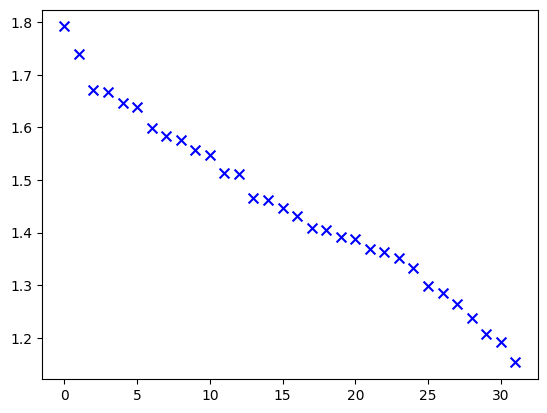

10
0.8774
32
reduced0:0.0


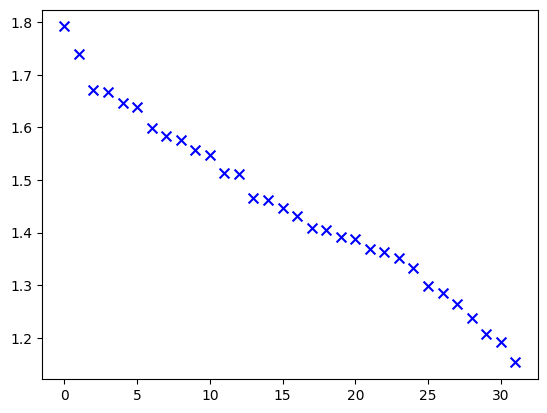

10
0.8774
32
reduced0:0.0


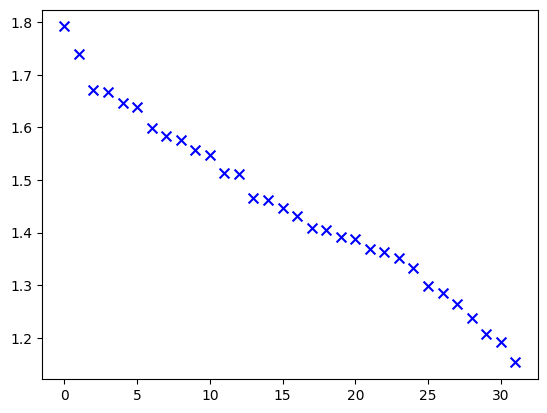

10
0.8774
32
reduced0:0.0


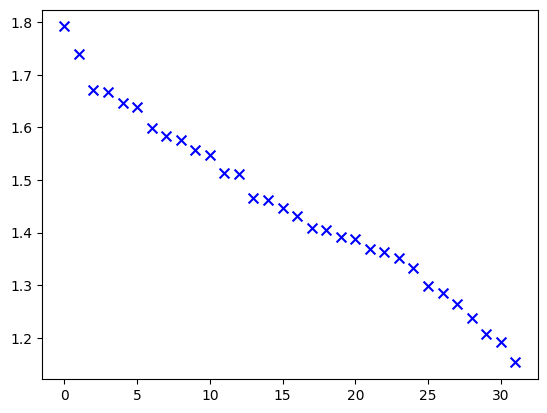

10
0.8774
32
reduced0:0.0


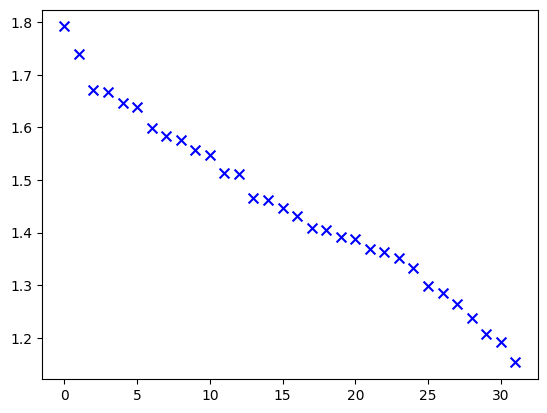

10
0.8774
32
reduced0:0.0


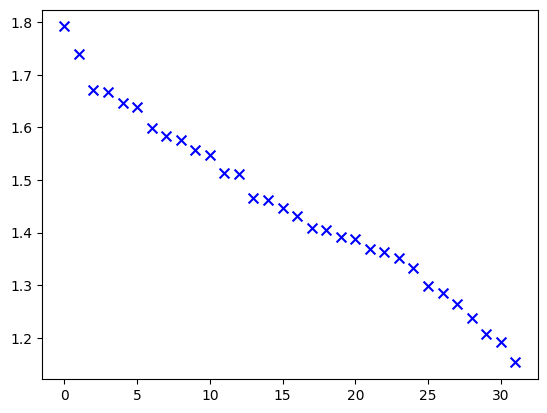

10
0.8774
32
reduced0:0.0


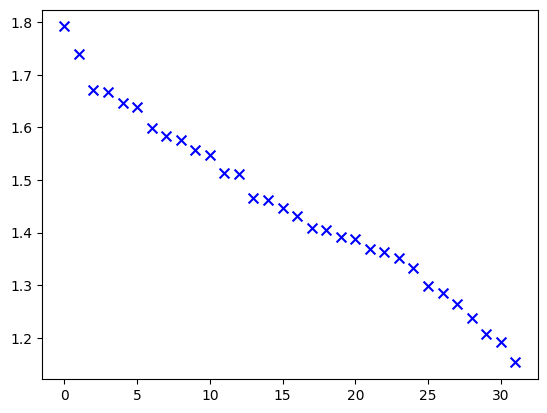

10
0.8774
32
reduced0:0.0


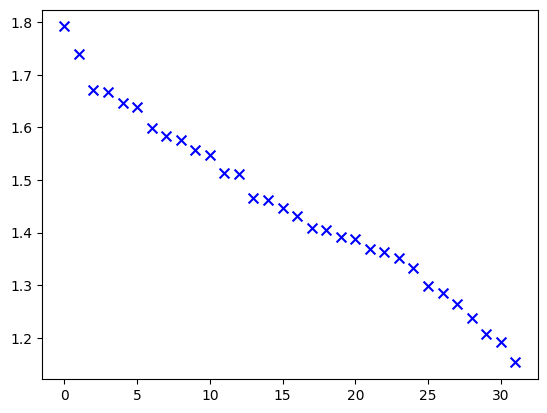

10
0.8774
32
reduced0:0.0


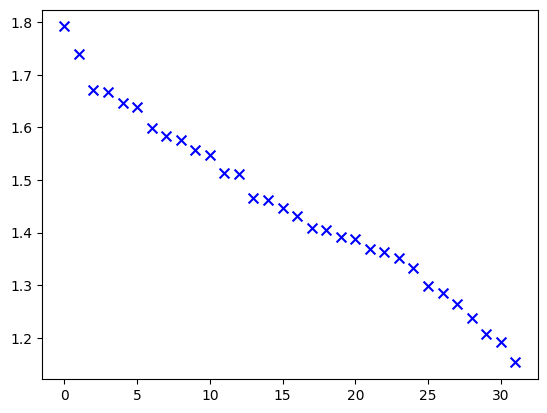

10
0.8774
32
reduced0:0.0


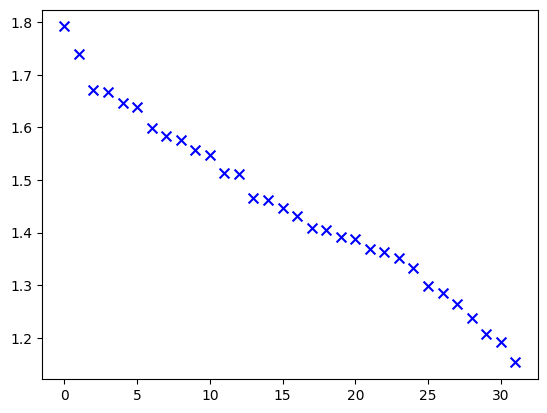

10
0.8774
32
reduced0:0.0


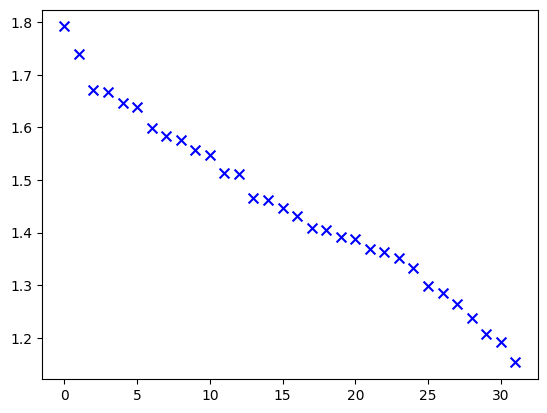

10
0.8774
32
reduced0:0.0


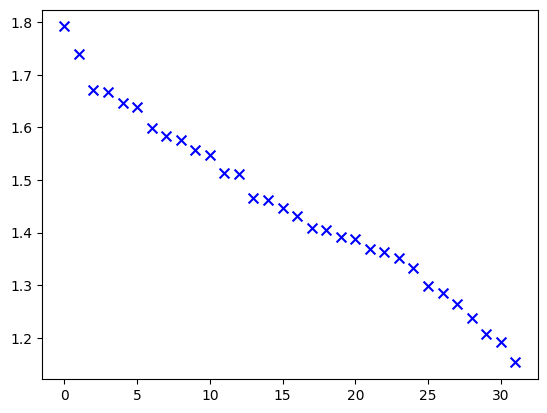

10
0.8774
32
reduced0:0.0


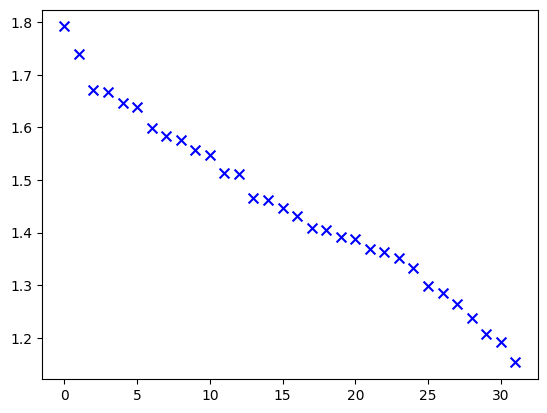

10
0.8774
32
reduced0:0.0


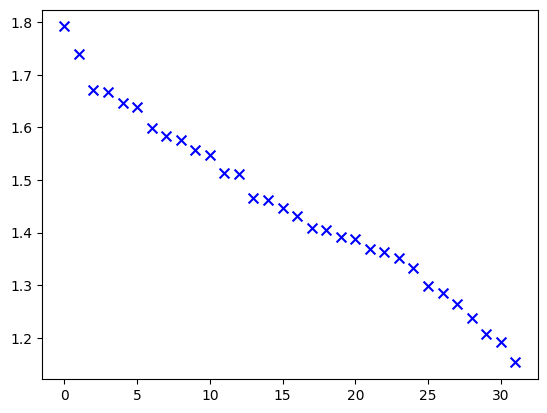

10
0.8774
32
reduced0:0.0


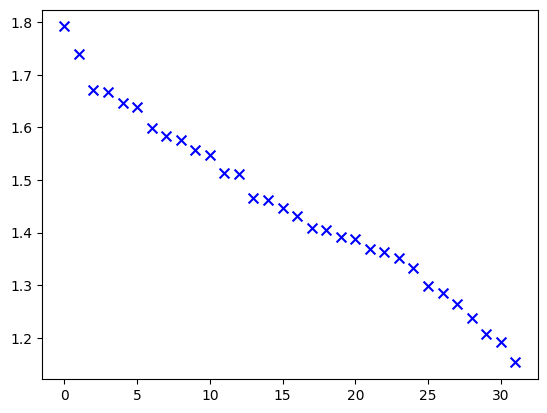

10
0.8774
32
reduced0:0.0


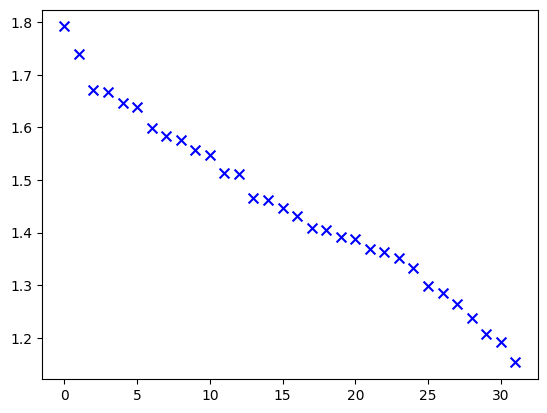

10
0.8774
32
reduced0:0.0


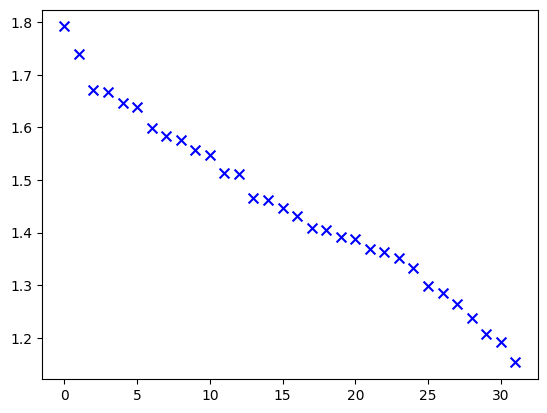

10
0.8774
32
reduced0:0.0


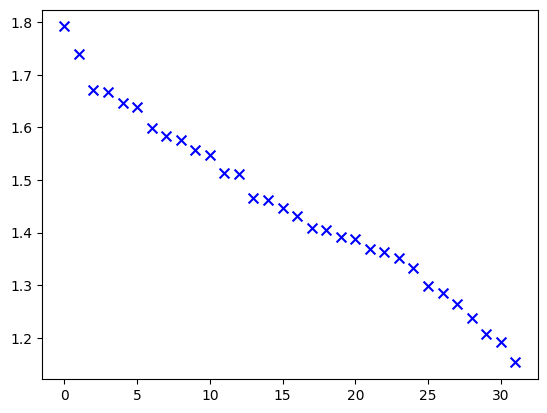

10
0.8774
32
reduced0:0.0


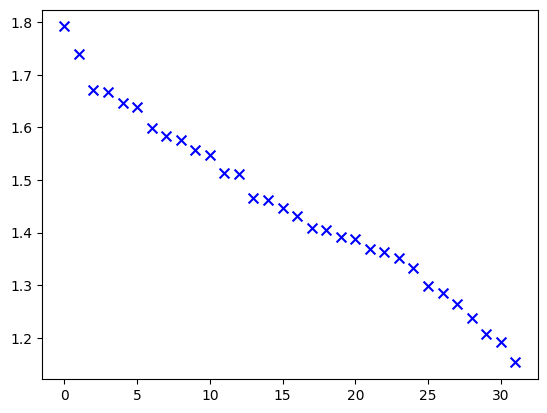

10
0.8774
32
reduced0:0.0


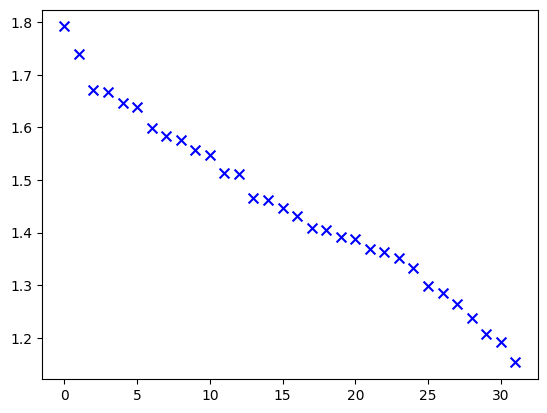

10
0.8774
32
reduced0:0.0


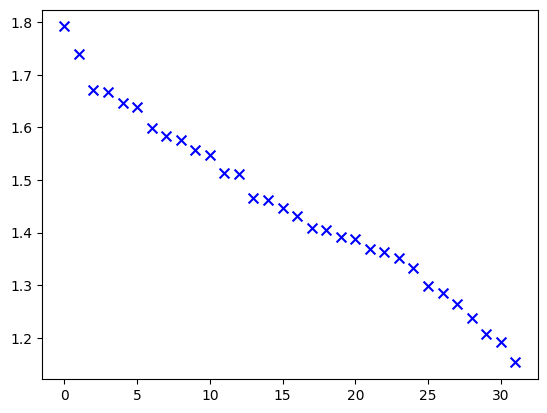

10
0.8774
32
reduced0:0.0


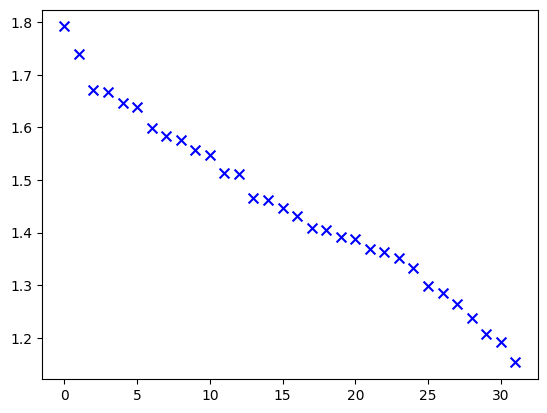

10
0.8774
32
reduced0:0.0


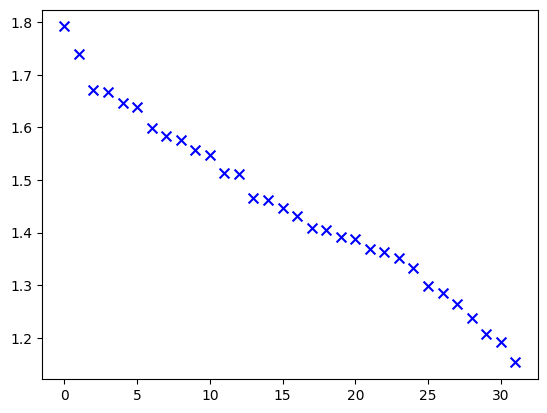

10
0.8774


In [36]:
import torch
import model
# from model import Bias
from torch import nn
import importlib
# importlib.reload(model)


def acc(model):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        
        for i in range(len(test_inputs)):
            outputs=model(test_inputs[i])
            _,predicted=torch.max(outputs.data,1)
            total+=len(predicted)
            correct+=(predicted==test_lables[i]).sum().item()
    model.train()
    return correct/total


mlp = torch.load('./mlp4.pth')
print(len(mlp.layers))


def svd(reduce,bound,k_down):
    for k,layer in enumerate(mlp.layers):
        if (isinstance(layer, torch.nn.Linear)):
            w=layer.weight
            b=layer.bias
            U,S,V=torch.linalg.svd(w.t())
            print(len(S))

            sort_index=torch.argsort(S)
            cnt=0
            sum=0
            for i in S.view(-1):
                sum+=i.item()
                if(i.item()<reduce):
                    cnt+=1
            
            if (len(S)<bound):
                reduce=reduce*k_down
                continue
            print(f"reduced{k}:{cnt/len(S)}")
            index_remove=sort_index[:cnt]
            # input()

            Vn_mask=torch.ones(V.size(0),dtype=torch.bool)
            Vm_mask=torch.ones(V.size(1),dtype=torch.bool)
            Un_mask=torch.ones(U.size(0),dtype=torch.bool)
            Um_mask=torch.ones(U.size(1),dtype=torch.bool)
            S_mask=torch.ones(S.size(0),dtype=torch.bool)
            for removei in index_remove:
                Vn_mask[removei]=False
                Vm_mask[removei]=False
                Un_mask[removei]=False
                Um_mask[removei]=False
                S_mask[removei]=False
            V=V[Vn_mask,:]
            U=U[:,Un_mask]
            S=S[S_mask]

            from matplotlib import pyplot as plt

            ls=[]
            for x in S.view(-1):
                ls.append(x.item())
            plt.scatter(np.arange(len(S)),ls,color='blue',marker='x',s=50)
            plt.show()
            
            nU=U.shape[0]
            mU=U.shape[1]
            nV=V.shape[0]
            mV=V.shape[1]
            nS=mU
            mS=nV

            S_diag = torch.zeros(nS,mS)
            for i in range(S.shape[0]):
                S_diag[i, i] = S[i]
            S=S_diag


            newlinear1=torch.nn.Linear(nU,mU,bias=False).to(device)
            newlinear2=torch.nn.Linear(nS,mS,bias=False).to(device)
            newlinear3=torch.nn.Linear(nV,mV,bias=False).to(device)
            newlinear1.weight=nn.Parameter(U.t())
            newlinear2.weight=nn.Parameter(S.t())
            newlinear3.weight=nn.Parameter(V.t())
            newbias=model.Bias(b)
            newbias=newbias.to(device)
            # print(newlinear1.weight.shape)
            # print(newlinear2.weight.shape)
            # print(newlinear3.weight.shape)
            # print('------------')
            svded=nn.Sequential(newlinear1,newlinear2,newlinear3,newbias)
            mlp.layers[k]=svded

from matplotlib import pylab as plt
y=[]
import numpy as np
bound=32
k_down=0
for i in np.arange(2, 0, -0.05):
    mlp = torch.load('./mlp4.pth')
    svd(i,bound,k_down)
    mlp.eval()
    mlp.to(device)
    # for layer in mlp.layers:
    #     if(isinstance(layer,torch.nn.Sequential)):
    #         for sublayer in layer:
    #             sublayer.to(device)
    #             if(not isinstance(sublayer,nn.Module)):
    #                 print(sublayer.weight.shape)
        # print('----------------')
    print(acc(mlp))
    y.append(acc(mlp))




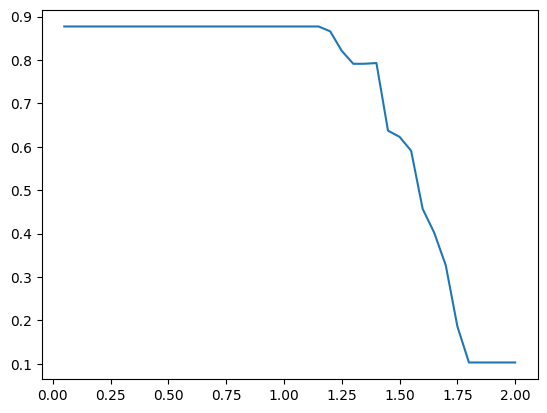

In [29]:
# plt.plot(y)
x=np.arange(2, 0, -0.05)
plt.plot(x,y)
plt.show()

In [ ]:
import torch
import model
# from model import Bias
from torch import nn
import importlib
import copy
# importlib.reload(model)


def acc(model):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        
        for i in range(len(test_inputs)):
            outputs=model(test_inputs[i])
            _,predicted=torch.max(outputs.data,1)
            total+=len(predicted)
            correct+=(predicted==test_lables[i]).sum().item()
    model.train()
    return correct/total


# mlp = torch.load('./mlp2.pth')
# print(len(mlp.layers))

def svd(reduce,boundup,boundown,mlp):
    for k,layer in enumerate(mlp.layers):
        # print(layer)
        if (isinstance(layer, torch.nn.Linear)):
            w=layer.weight
            w=w.to(device)
            b=layer.bias
            U,S,V=torch.linalg.svd(w)
            # print(U)
            nU=U.shape[0]
            mU=U.shape[1]
            nV=V.shape[0]
            mV=V.shape[1]
            nS=mU
            mS=nV

            if(min(nU,nV)>=boundown and min(nU,nV)<=boundup):
                r=int(min(nU,nV)*reduce)
                # print('r:'+str(r))
            else:
                r=int(min(nU,nV))
                continue
            
            U=U[:,:r]
            mU=r
            V=V[:r,]
            nV=r

            S_diag = torch.zeros(nS,mS)
            for i in range(S.shape[0]):
                S_diag[i, i] = S[i]
            S=S_diag

            S=S[:r,:r]
            nS=r
            mS=r


            newlinear1=torch.nn.Linear(nU,mU,bias=False).to(device)
            newlinear2=torch.nn.Linear(nS,mS,bias=False).to(device)
            newlinear3=torch.nn.Linear(nV,mV,bias=False).to(device)
            newlinear1.weight=nn.Parameter(U)
            newlinear2.weight=nn.Parameter(S)
            newlinear3.weight=nn.Parameter(V)
            newbias=model.Bias(b)
            newbias=newbias.to(device)
            # print(newlinear1.weight.shape)
            # print(newlinear2.weight.shape)
            # print(newlinear3.weight.shape)
            # print('------------')
            svded=nn.Sequential(newlinear3,newlinear2,newlinear1,newbias).to(device)
            mlp.layers[k]=svded

from matplotlib import pylab as plt
y1=[]
y2=[]
import numpy as np
boundown=1513
boundup=4096
for i in np.arange(1, 0.2, -0.1):
    mlp = torch.load('./mlp3.pth')
    mlp.to(device)
    svd(i,boundup=boundup,boundown=boundown,mlp=mlp)
    boundown2=800
    boundup2=1513
    yi2=[]
    for j in np.arange(1,0,-0.1):
        # print('down----')
        mlp2=copy.deepcopy(mlp)
        svd(j,boundup=boundup2,boundown=boundown2,mlp=mlp2)
        # print('----')

        print(acc(mlp2))
        yi2.append(acc(mlp2))
    y2.append(yi2)
    y1.append(acc(mlp))
    print('-------')

# plt.plot(np.arange(1,0,-0.02),y)
# plt.plot(y1)
# plt.plot(y2)
# plt.show()


/tmp/ipykernel_2070656/82542660.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp = torch.load('./mlp3.pth')


0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------
0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------
0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------
0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------
0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------
0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------
0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------
0.9429
0.9423
0.9404
0.9324
0.9072
0.7223
0.7843
0.4354
0.269
0.0953
-------


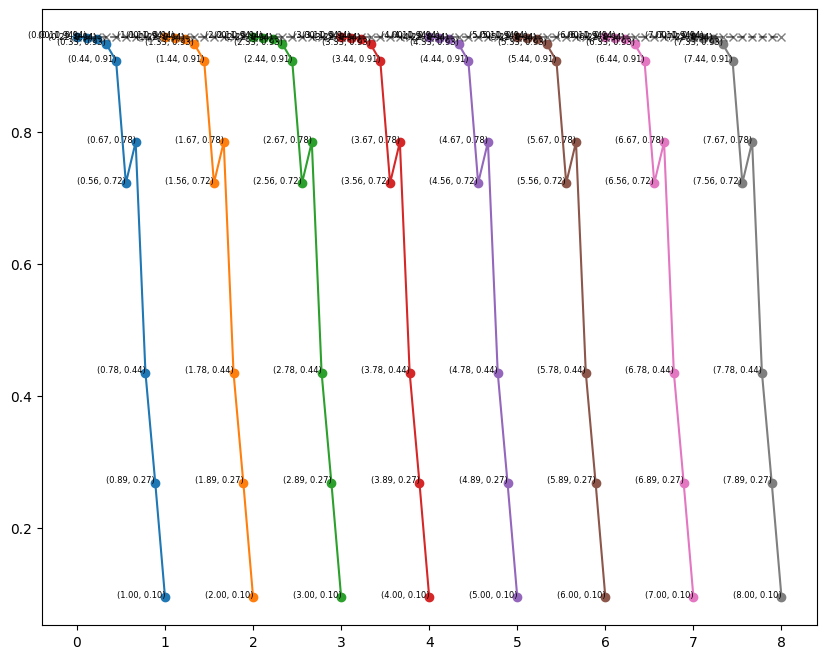

In [4]:
plt.figure(figsize=(10, 8))
for i in range(len(y1)):
    x = np.linspace(i, i + 1, len(y2[i]))  # 横坐标 1-5 偏移到 i-i+1 区间
    for j in range(len(y2[i])):
        plt.text(x[j], y2[i][j], f'({x[j]:.2f}, {y2[i][j]:.2f})', ha='right', fontsize=6)
    plt.plot(x, y2[i], marker='o', linestyle='-', label=f'第 {i+1} 组第二组数据')
    plt.plot(x, [y1[i]] * len(y2[i]), marker='x', linestyle='--', color='black', alpha=0.5, label=f'第 {i+1} 个第一组数据')
plt.show()

In [59]:
import torch
import model
# from model import Bias
from torch import nn
import importlib
# importlib.reload(model)


def acc(model):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        
        for i in range(len(test_inputs)):
            outputs=model(test_inputs[i])
            _,predicted=torch.max(outputs.data,1)
            total+=len(predicted)
            correct+=(predicted==test_lables[i]).sum().item()
    model.train()
    return correct/total


mlp = torch.load('./mlp4.pth')
print(len(mlp.layers))


def svd(reduce,bound,k_down):
    for k,layer in enumerate(mlp.layers):
        if (isinstance(layer, torch.nn.Linear)):
            w=layer.weight
            b=layer.bias
            U,S,V=torch.linalg.svd(w.t())

            sort_index=torch.argsort(S)
            cnt=0
            sum=0
            for i in S.view(-1):
                sum+=i.item()
                if(i.item()<reduce):
                    cnt+=1
            
            if (len(S)<bound):
                reduce=reduce*k_down
                continue
            print(f"reduced{k}:{reduce}")
            
            r=int(len(S)*reduce)
            print(r)
            S_diag = torch.zeros(r,r)
            for i in range(r):
                S_diag[i, i] = S[i]
            nU=U.shape[0]
            mU=r
            nV=r
            mV=V.shape[1]
            nS=mS=r


            
            U=U[:,:mU]
            V=V[:nV,]
            
            
            print(U.shape)
            print(S_diag.shape)
            print(V.shape)

            newlinear1=torch.nn.Linear(nU,mU,bias=False).to(device)
            newlinear2=torch.nn.Linear(nS,mS,bias=False).to(device)
            newlinear3=torch.nn.Linear(nV,mV,bias=False).to(device)
            newlinear1.weight=nn.Parameter(U.t())
            newlinear2.weight=nn.Parameter(S_diag.t())
            newlinear3.weight=nn.Parameter(V.t())
            newbias=model.Bias(b)
            newbias=newbias.to(device)
            # print(newlinear1.weight.shape)
            # print(newlinear2.weight.shape)
            # print(newlinear3.weight.shape)
            # print('------------')
            svded=nn.Sequential(newlinear1,newlinear2,newlinear3,newbias)
            mlp.layers[k]=svded

from matplotlib import pylab as plt
y=[]
import numpy as np
bound=32
k_down=0
for i in np.arange(1, 0, -0.001):
    mlp = torch.load('./mlp4.pth')
    svd(i,bound,k_down)
    mlp.eval()
    mlp.to(device)
    # for layer in mlp.layers:
    #     if(isinstance(layer,torch.nn.Sequential)):
    #         for sublayer in layer:
    #             sublayer.to(device)
    #             if(not isinstance(sublayer,nn.Module)):
    #                 print(sublayer.weight.shape)
        # print('----------------')
    print(acc(mlp))
    y.append(acc(mlp))




/tmp/ipykernel_2190524/3218014642.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp = torch.load('./mlp4.pth')
/tmp/ipykernel_2190524/3218014642.py:90: FutureWarning:

3
reduced0:1.0
32
torch.Size([784, 32])
torch.Size([32, 32])
torch.Size([32, 32])
0.8774
reduced0:0.999
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.998
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.997
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.996
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.995
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.994
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.993
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.992
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.991
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.99
31
torch.Size([784, 31])
torch.Size([31, 31])
torch.Size([31, 32])
0.8746
reduced0:0.989
31
torc

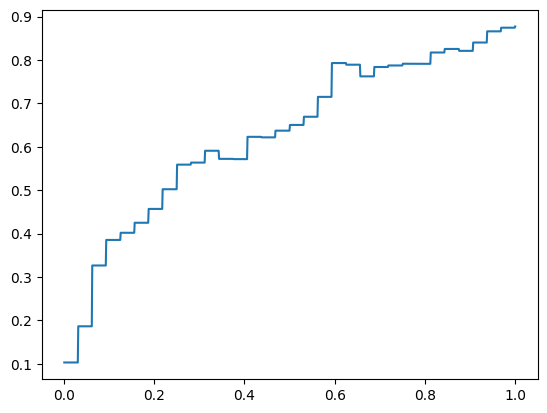

In [ ]:
x=np.arange(1, 0, -0.001)
plt.plot(x,y)
plt.show()